# Data Science For Biology 2025 Final Project: Mutagenesis Development and Lead Protein Sequence Screening

## Libraries and Packages

In [47]:
!pip install metapredict


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [48]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import joblib
from tqdm import tqdm
import metapredict as meta
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel
import torch
from dotenv import load_dotenv
import os

# Set random seed for reproducibility
np.random.seed(42)

## Screen For ADseq with Low SCGlucose Activity
Here I will load in the data as usual, but this time, I will sort by Activity_SCglucose in ascending order to have easier access to ADseq's which express low activity

In [49]:
data = pd.read_csv("./data/gcn4-orthologs.csv")
data = data.rename(columns={data.columns[0]: "tile_id"})
data.head()

,tile_id,DNAseq,ADseq,numreads_per_AD_7AGFP_AAS,Activity_7AGFP_AAS,numreads_per_AD_8AmCh_AAS,Activity_8AmCh_AAS,numreads_per_AD_9ARatio_AAS,Activity_9ARatio_AAS,numreads_per_AD_10BRatio_AAS,...,Activity_BYS4_BioRepAverage,Stdev_BYS4_BioReps,Activity_SCglucose,Start,Recovered,Activity_SCgalactose,Activity_P3promoter,Activity_P14promoter,Activity_P15promoter,Activity_P3promoterMig1TFBSremoved
0,0,AAAAATTCTAGATTTGTTTCTTTGATGCAAGGATTCTCTGATGGTT...,KNSRFVSLMQGFSDGSKDIIDNEVREVGDFSVNKPPQADD,NaN,NaN,NaN,NaN,NaN,NaN,3151.0,...,NaN,NaN,11666.48682,341,True,97250.68362,NaN,11149.49032,NaN,8040.343648
1,1,AAAAATTCTCCATCTGGTTTGGCTCATTCTTCTGTTTCTGGTGTTG...,KNSPSGLAHSSVSGVGKSRRRKGPLPPITVQDPSDKTAIK,942.0,709.606092,367.0,2921.917252,601.0,22242.74698,6909.0,...,21968.05843,5849.143385,21968.05843,146,True,15516.96245,14570.13217,16872.28649,11555.08411,10255.296840
2,2,AAACAAAATTCTCAAGTTGATCAATCTCCATTGTTGCCAGAAGAAG...,KQNSQVDQSPLLPEEELEVSEHLRRRRSGTATSPPAGGVR,NaN,NaN,NaN,NaN,NaN,NaN,6577.0,...,NaN,NaN,21203.02478,326,True,0.00000,18274.98241,15702.60901,18303.29201,17265.783330
3,3,AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...,KQRATPLTPVVPESDDPVALKRARNTEAARRSRARKLERM,357.0,1039.469842,342.0,1089.428196,450.0,74251.36241,NaN,...,NaN,NaN,47244.41248,246,True,92844.00000,NaN,NaN,NaN,84807.518160
4,4,AAACAAAGATCTATTCCATTGTCTCCAATTGTTCCAGAATCTTCTG...,KQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRM,539.0,1081.980998,627.0,622.131501,586.0,58872.95132,128.0,...,95093.69451,13292.686710,95093.69451,211,True,76399.62949,NaN,125056.17980,129302.35080,100360.735500


In [50]:
# Sort by activity
activity = "Activity_SCglucose"
low_activity_df = data.sort_values(by=[activity], ascending=True)
low_activity_df = low_activity_df[['ADseq', activity]].dropna()
low_activity_df


,ADseq,Activity_SCglucose
9175,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN,6138.0
9585,DDKAAGDSAPVDSAPALVKQPSTTPLDSPAPLIMDTYTRR,6138.0
3711,RKLERQDVMERRIAELEKSLEEAEQREQYWKAMAQAQTQV,6138.0
2712,TLAARKSRQRKMQRFEELEDQIAKLEAERDHWKEIALRRS,6138.0
8564,EAARRSRARKMERMNQLEDKVEDLVGEKQALQDEVDRLKS,6138.0
...,...,...
6161,HANRGPDFDALFDLTANSFVDGLDAASLAMFDTQQLDKVQ,262143.0
1541,TTFNNTQAQQEFPSIMSTSSIPQDFDALFDLTANSFVDGL,262143.0
11857,GTISPQDLMMDASAPPSASLTDLSTPSFESPGYFSQDPSP,262143.0
6726,PMFEFESLDESNDPKNWTSLFENDLPIITEDDVSLNDKAI,262143.0


In [51]:
# Let's look at the min and max values of the activity
low_activity_df.describe()

,Activity_SCglucose
count,18944.000000
mean,66087.894674
std,61869.279225
min,6138.000000
25%,24438.359877
50%,43490.494810
75%,77276.723883
max,262143.000000


## In Silico Directed Evolution
Without loss of generality, let's simply pick the protein sequence with the lowest activity and do some a random pointwise mutation. We then repeat this process across $N$ generations. First I will add sequence features so that we can use the random forest model to predict the SCGlucose activity. The reason for this is because the model is very strict with the columns we provide for prediction. It must be named and ordered exactly the same as how we trained the model initially or scikit-learn will complain!

In [52]:
# FEATURES

# variables I need glovally
AA_LIST = 'ACDEFGHIKLMNPQRSTVWY'
AA_COLS = [f"AA_{aa}" for aa in AA_LIST]

# I use Kyte-Doolittle scale for hydrophobicity hereee CHECK WITH PROF STALLER
# https://www.rbvi.ucsf.edu/chimera/docs/UsersGuide/midas/hydrophob.html
KD_HYDROPHOBICITY = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

# i use the tuple here for naming the motifs
MOTIFS = [
    ("W..LF", "W..LF"),
    ("WFYL_WFYL", "[WFYL]..[WFYL][WFYL]"),
    ("WFL_WFL", "[WFL]..[WFL][WFL]"),
    ("DE_WFY", "[DE][WFY]"),
    ("DE_WF", "[DE][WF]"),
    ("DE_L", "[DE][L]"),
    ("DE_x_WFY", "[DE].[WFY]"),
    ("DE_xx_WFY", "[DE]..[WFY]"),
    ("FF", "FF"),
    ("F_F", "F.F"),
    ("F__F", "F..F"),
    ("FY_5x_FY", "[FY].....[FY]"),
    ("SP", "SP"),
    ("WFYL_3x_WFYL", "[WFYL]...[WFYL][WFYL]")
]

# FUNCTIONS TO CALC

def amino_acid_count(sequence: str) -> dict[str, int]:
    c = Counter(sequence)
    return {f"AA_{aa}": c.get(aa, 0) for aa in AA_LIST}

def net_charge(seq: str) -> int:
    charge_map = {"K": 1, "R": 1, "D": -1, "E": -1}
    return sum(charge_map.get(a, 0) for a in seq)

def hydrophobicity(sequence: str) -> float:
    total_hydrophobicity = sum(KD_HYDROPHOBICITY[aa] for aa in sequence if aa in KD_HYDROPHOBICITY)
    return total_hydrophobicity

def motif_counts_dict(seq: str) -> dict[str, int]:
    return {name: len(re.findall(pat, seq)) for name, pat in MOTIFS}

# APPLY DA FEATURESSSS
def add_sequence_features(df: pd.DataFrame, seq_col: str = "ADseq") -> pd.DataFrame:
    # AA composition
    aa_expanded = df[seq_col].apply(amino_acid_count).apply(pd.Series)
    
    # Motif counts
    motif_expanded = df[seq_col].apply(motif_counts_dict).apply(pd.Series)

    # Scalar features
    df["NetCharge"] = df[seq_col].apply(net_charge)
    df["Hydrophobicity"] = df[seq_col].apply(hydrophobicity)
    
    # Sequence length
    df["Length"] = df[seq_col].str.len()

    # Combine everything
    result_df = pd.concat([df, aa_expanded, motif_expanded], axis=1)

    return result_df

In [53]:
low_activity_df = add_sequence_features(low_activity_df, seq_col="ADseq")

# now we put activity as the last column for convenience
low_activity_df = low_activity_df[[col for col in low_activity_df.columns if col != activity] + [activity]]
low_activity_df.head()

,ADseq,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,AA_G,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
9175,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN,0,-26.6,40,2,0,2,0,3,1,...,0,0,0,0,0,1,0,1,0,6138.0
9585,DDKAAGDSAPVDSAPALVKQPSTTPLDSPAPLIMDTYTRR,-2,-21.6,40,6,0,6,0,0,1,...,0,1,0,0,0,0,0,1,0,6138.0
3711,RKLERQDVMERRIAELEKSLEEAEQREQYWKAMAQAQTQV,-1,-53.3,40,5,0,1,8,0,0,...,1,1,1,0,0,0,0,0,0,6138.0
2712,TLAARKSRQRKMQRFEELEDQIAKLEAERDHWKEIALRRS,3,-54.1,40,5,0,2,6,1,0,...,1,1,0,0,0,0,0,0,0,6138.0
8564,EAARRSRARKMERMNQLEDKVEDLVGEKQALQDEVDRLKS,0,-54.8,40,4,0,4,6,0,1,...,1,0,0,0,0,0,0,0,0,6138.0


Great! Now what we're going to do is simply take the first row which corresponds to the ADseq with low SCglucose activity. We will also take note of its corresponding activity value for comparison later on!

In [54]:
protein_sequence = low_activity_df.iloc[0, 0]
activity_value = low_activity_df.iloc[0, -1]
print(f"Protein sequence: {protein_sequence}")
print(f"Activity value: {activity_value}")

Protein sequence: DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN
Activity value: 6138.0


Below I define two functions. The first `mutate_sequence` allows us do a single pointwise mutation on the protein sequence in a controlled manner where we can specify the position and the replacing amino acid for the selected protein sequence. The second, `simulate_mutations_over_generations` is an algorithm I developed to perform in silico directed evolution. The key idea is simple: starting from a single protein sequence, we simulate evolutionary pressure by introducing pointwise mutations over multiple generations.

In each generation:

1. We create many mutated versions of the current sequences by randomly changing one amino acid at a time.

2. These new sequences are passed through a custom function that evaluates their properties (e.g., activity, structure, or other learned features).

3. We keep the most promising variants and use them as the parents for the next generation.

Over each generation, the idea is that this process mimics natural selection but virtually

In [83]:
def simulate_mutations_over_generations(
    initial_sequence: str,
    aa_list: list[str],
    add_features_fn,
    num_generations: int = 10,
    num_mutations_per_generation: int = 1_000,
    max_sequences_per_gen: int = 5_000,
    min_disorder_threshold: float = 0.5
):

    current_sequences = [initial_sequence]
    all_dfs = []

    for gen in tqdm(range(num_generations), desc="Generation"):
        parent_count = len(current_sequences)
        total_events = num_mutations_per_generation

        # Randomly select mutation sites and residues
        parents = np.random.randint(0, parent_count, size=total_events)
        positions = np.random.randint(0, len(initial_sequence), size=total_events)
        new_aas = np.random.choice(aa_list, size=total_events)

        # Create unique mutant sequences
        mutated = {
            current_sequences[p][:pos] + aa + current_sequences[p][pos + 1:]
            for p, pos, aa in zip(parents, positions, new_aas)
        }
        mutated_list = list(mutated)
        tqdm.write(f"Gen {gen+1}: {len(mutated_list)} unique mutants created")

        # Filter mutants by minimum disorder threshold
        filtered_mutants = []
        for seq in tqdm(mutated_list, desc="Filtering by disorder threshold"):
            disorder = np.array(meta.predict_disorder(seq))
            if disorder.mean() >= min_disorder_threshold:
                filtered_mutants.append(seq)

        # Cap total number to max_sequences_per_gen
        mutated_list = filtered_mutants[:max_sequences_per_gen]
        tqdm.write(f"  → {len(mutated_list)} mutants kept (passed threshold)")

        # Stop early if no viable sequences remain
        if not mutated_list:
            tqdm.write("  → No viable sequences passed the threshold. Halting.")
            break

        # Add features to the valid sequences
        df = pd.DataFrame({"ADseq": mutated_list})
        df["Generation"] = gen + 1
        df = add_features_fn(df, seq_col="ADseq")

        all_dfs.append(df)
        current_sequences = mutated_list

    return pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()


In [84]:
result = simulate_mutations_over_generations(
    protein_sequence, 
    list(AA_LIST), 
    add_sequence_features,
    num_generations=5, 
    num_mutations_per_generation=5000
)


Generation:   0%|          | 0/5 [00:00<?, ?it/s]

Gen 1: 760 unique mutants created


Generation:   0%|          | 0/5 [00:01<?, ?it/s]

  → 760 mutants kept (passed threshold)


Generation:  20%|██        | 1/5 [00:01<00:06,  1.64s/it]

Gen 2: 4881 unique mutants created


Generation:  20%|██        | 1/5 [00:09<00:06,  1.64s/it]

  → 4881 mutants kept (passed threshold)


Generation:  40%|████      | 2/5 [00:11<00:18,  6.28s/it]

Gen 3: 4988 unique mutants created


Generation:  40%|████      | 2/5 [00:21<00:18,  6.28s/it]

  → 4988 mutants kept (passed threshold)


Generation:  60%|██████    | 3/5 [00:22<00:17,  8.66s/it]

Gen 4: 4994 unique mutants created


Generation:  60%|██████    | 3/5 [00:32<00:17,  8.66s/it]

  → 4994 mutants kept (passed threshold)


Generation:  80%|████████  | 4/5 [00:34<00:09,  9.95s/it]

Gen 5: 4990 unique mutants created


Generation:  80%|████████  | 4/5 [00:45<00:09,  9.95s/it]

  → 4990 mutants kept (passed threshold)


Generation: 100%|██████████| 5/5 [00:47<00:00,  9.47s/it]


In [85]:
result.head()

,ADseq,Generation,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,...,DE_WF,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL
0,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFESLQSNTTSTN,1,-1,-29.7,40,2,0,2,1,3,...,1,0,0,0,0,0,1,0,1,0
1,DFVLFDSPQPQRTTVNRPSSTPSNSAAPFGSLQSNTTSTN,1,0,-31.5,40,2,0,2,0,3,...,1,0,0,0,0,0,1,0,1,0
2,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTETN,1,-1,-29.3,40,2,0,2,1,3,...,1,0,0,0,0,0,1,0,1,0
3,DFVLFDSPQPQRTGVNRPSSVPSNSAAPFGSLQSNTTSTN,1,0,-26.3,40,2,0,2,0,3,...,1,0,0,0,0,0,1,0,1,0
4,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNDTSTN,1,-1,-29.4,40,2,0,3,0,3,...,1,0,0,0,0,0,1,0,1,0


Now that we have our mutated sequences, we will use use our trained model from the activity-predictor notebook where in this case I'm using the random forest model trained only on computed features and not utilizing ESM embeddings since it scored the best in terms of Pearson R^2. We will use the random forest model to predict the activity_SCglucose for our mutated sequences!

In [86]:
# ==========================
# ESM2 Feature Embedding Computation
# ==========================

# Load the .env file
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

# Load model and tokenizer once
model_id = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
model = AutoModel.from_pretrained(model_id, token=hf_token)
model.eval()

def generate_embedding(sequence):
    """Generate pooled ESM embedding for a protein sequence."""
    input_ids = tokenizer(sequence, return_tensors="pt").input_ids
    attention_mask = torch.ones_like(input_ids)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        sequence_embeddings = outputs.last_hidden_state.squeeze()

    # Remove special tokens [CLS], [EOS]
    sequence_embeddings = sequence_embeddings[1:-1]

    # Mean-pool across residues
    pooled_embedding = sequence_embeddings.mean(dim=0)  # shape: (hidden_size,)
    return pooled_embedding.cpu().numpy()

def save_embeddings_to_npz(data, sequence_column, save_path):
    """Generate embeddings for all sequences and save into a single NPZ file."""
    all_embeddings = []

    for sequence in tqdm(data[sequence_column], desc="Generating embeddings"):
        embedding = generate_embedding(sequence)
        all_embeddings.append(embedding)

    all_embeddings = np.stack(all_embeddings)  # Shape: (num_sequences, hidden_dim)

    np.savez_compressed(save_path, embeddings=all_embeddings)
    print(f"Saved {len(all_embeddings)} embeddings to {save_path}")

    return all_embeddings

/home/qamil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
model_name = "./models/random_forest_model.pkl"

# Load the regression model
model = joblib.load(model_name)

if model_name.split("/")[-1].split("_")[0] == "esm":
    mutated_seq_embeddings = save_embeddings_to_npz(result, "ADseq", "./feature-embeddings/mutated_seq_embeddings.npz")
    embeddings_df = pd.DataFrame(mutated_seq_embeddings)
    embeddings_df.columns = [f"embedding_{i}" for i in range(embeddings_df.shape[1])]
    mutated_feature =result.drop(columns=["ADseq", "Generation"])   
    mutated_feature = pd.concat([mutated_feature, embeddings_df], axis=1)
    
else: 
    mutated_feature = result.drop(columns=["ADseq", "Generation"])

# Make predictions on the mutated sequence
predictions = model.predict(mutated_feature)

# Add predictions to the DataFrame
result[activity] = predictions

result.head()

,ADseq,Generation,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
0,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFESLQSNTTSTN,1,-1,-29.7,40,2,0,2,1,3,...,0,0,0,0,0,1,0,1,0,38856.582304
1,DFVLFDSPQPQRTTVNRPSSTPSNSAAPFGSLQSNTTSTN,1,0,-31.5,40,2,0,2,0,3,...,0,0,0,0,0,1,0,1,0,32052.186219
2,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTETN,1,-1,-29.3,40,2,0,2,1,3,...,0,0,0,0,0,1,0,1,0,36136.940333
3,DFVLFDSPQPQRTGVNRPSSVPSNSAAPFGSLQSNTTSTN,1,0,-26.3,40,2,0,2,0,3,...,0,0,0,0,0,1,0,1,0,46501.112803
4,DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNDTSTN,1,-1,-29.4,40,2,0,3,0,3,...,0,0,0,0,0,1,0,1,0,30811.471318


Naturally the next thing to do is to find which of these mutations is predicted to have the highest scglucose_activity. We'll then perform a more thorough analysis on this sequence

In [88]:
highest_activity_candidates = result.sort_values(by=[activity], ascending=False)
highest_activity_candidates

,ADseq,Generation,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
18735,DFVLFDSPQPQRDTVDRPSSPPSNSAAPFGDLFSNTTSTN,5,-3,-31.6,40,2,0,5,0,4,...,1,1,0,0,0,1,0,2,0,122001.829911
9179,DFVLFDEPQPQETTVNRPSSVPSNSAAPFGSLFSNTTSTN,3,-3,-22.0,40,2,0,2,2,4,...,0,0,0,0,0,1,0,0,0,116065.081795
17302,DFVLFDSFWPQRTTVNRPSSVNSNSEAPFGSLQSNTTSTN,5,-1,-26.8,40,1,0,2,1,4,...,0,1,2,0,0,1,1,0,1,113008.097177
10870,DFVLFDSFWPQRTTVNRPSSVPSNSEAPFGSLQSNTTSTN,4,-1,-24.9,40,1,0,2,1,4,...,0,1,2,0,0,1,1,0,1,112356.020044
5894,DFVLFDSFWPQRTTVNRPSSVPSNSEAPFGSLQSNTTSTN,3,-1,-24.9,40,1,0,2,1,4,...,0,1,2,0,0,1,1,0,1,112356.020044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3910,DAVLGDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN,2,0,-30.8,40,3,0,2,0,1,...,0,0,0,0,0,0,0,1,0,21222.295304
17008,DTKLFDSPQPERTTVNRPSSVPSNSAAPMGSDQSNTTSTN,5,-1,-46.4,40,2,0,3,1,1,...,0,0,0,0,0,0,0,1,0,21182.918663
16103,DDVLMDSPQPQRTTVNRQSSKPSNSAAPFGSLQSNLTSTN,5,0,-39.3,40,2,0,3,0,1,...,0,0,0,0,0,0,0,1,0,21139.755210
7426,DSVLNDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSAN,3,0,-34.0,40,3,0,2,0,1,...,0,0,0,0,0,0,0,1,0,20680.261695


Now let's take the top 500 rows based on activity in descending order which will get us the highest activity mutants

In [92]:
top_500 = highest_activity_candidates.head(500)
top_500.head()

,ADseq,Generation,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
18735,DFVLFDSPQPQRDTVDRPSSPPSNSAAPFGDLFSNTTSTN,5,-3,-31.6,40,2,0,5,0,4,...,1,1,0,0,0,1,0,2,0,122001.829911
9179,DFVLFDEPQPQETTVNRPSSVPSNSAAPFGSLFSNTTSTN,3,-3,-22.0,40,2,0,2,2,4,...,0,0,0,0,0,1,0,0,0,116065.081795
17302,DFVLFDSFWPQRTTVNRPSSVNSNSEAPFGSLQSNTTSTN,5,-1,-26.8,40,1,0,2,1,4,...,0,1,2,0,0,1,1,0,1,113008.097177
10870,DFVLFDSFWPQRTTVNRPSSVPSNSEAPFGSLQSNTTSTN,4,-1,-24.9,40,1,0,2,1,4,...,0,1,2,0,0,1,1,0,1,112356.020044
5894,DFVLFDSFWPQRTTVNRPSSVPSNSEAPFGSLQSNTTSTN,3,-1,-24.9,40,1,0,2,1,4,...,0,1,2,0,0,1,1,0,1,112356.020044


### Cross-Examination Between Original and Mutated Sequences\

In [94]:
top_candidate = top_500.iloc[0]
print(f"Top candidate sequence: {top_candidate['ADseq']}")
print(f"Original sequence: {protein_sequence}")
print(f"Original activity: {activity_value}")
print(f"Predicted activity: {top_candidate[activity]}")

Top candidate sequence: DFVLFDSPQPQRDTVDRPSSPPSNSAAPFGDLFSNTTSTN
Original sequence: DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN
Original activity: 6138.0
Predicted activity: 122001.82991100001


In [95]:
# i wanna see how these two are different
def compare_sequences(seq1: str, seq2: str) -> list[tuple[int, str, str]]:
    differences = []
    for i, (a, b) in enumerate(zip(seq1, seq2)):
        if a != b:
            differences.append((i, a, b))
    return differences
differences = compare_sequences(protein_sequence, top_candidate["ADseq"])
print("Differences between original and top candidate:")
for pos, original_aa, new_aa in differences:
    print(f"Position {pos}: {original_aa} -> {new_aa}")

Differences between original and top candidate:
Position 12: T -> D
Position 15: N -> D
Position 20: V -> P
Position 30: S -> D
Position 32: Q -> F


In [96]:
# Let's check the difference in net charge and hydrophobicity
original_net_charge = net_charge(protein_sequence)
top_candidate_net_charge = net_charge(top_candidate["ADseq"])
print(f"Original net charge: {original_net_charge}")
print(f"Top candidate net charge: {top_candidate_net_charge}")
print(f"Net charge difference: {top_candidate_net_charge - original_net_charge}")


original_hydrophobicity = hydrophobicity(protein_sequence)
top_candidate_hydrophobicity = hydrophobicity(top_candidate["ADseq"])
print(f"Original hydrophobicity: {original_hydrophobicity}")
print(f"Top candidate hydrophobicity: {top_candidate_hydrophobicity}")
print(f"Hydrophobicity difference: {top_candidate_hydrophobicity - original_hydrophobicity}")

Original net charge: 0
Top candidate net charge: -3
Net charge difference: -3
Original hydrophobicity: -26.599999999999998
Top candidate hydrophobicity: -31.6
Hydrophobicity difference: -5.0000000000000036


### Disorder Analysis with Meta Predict

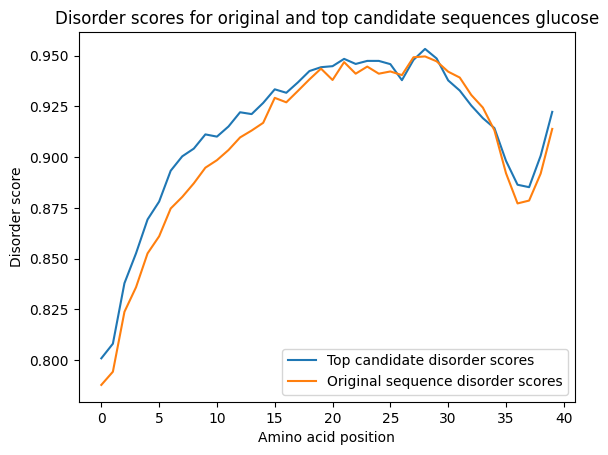

In [97]:
top_candidate_disorder_scores = meta.predict_disorder(top_candidate["ADseq"])
original_sequence_disorder_scores = meta.predict_disorder(protein_sequence)

plt.plot(top_candidate_disorder_scores, label="Top candidate disorder scores")
plt.plot(original_sequence_disorder_scores, label="Original sequence disorder scores")
plt.xlabel("Amino acid position")
plt.ylabel("Disorder score")
plt.title("Disorder scores for original and top candidate sequences glucose")
plt.legend()
plt.show()


I believe what we can tell from this is that our top candidate here is likely to maintain the intrinsically disordered structure characteristic of functional activation domains. The plot above shows that the improved predicted activity did not come at the cost of order-disorder balance which is a good things and it might even hint at the possibility that slight modulation in specific regions could be beneficial

### Save Top 500 Sequences To CSV

In [67]:
# Save the top 500 sequences to a CSV file
top_500 = sorted_disorder.head(500)
top_500.to_csv(f"top_500_sequences_{activity}.csv", index=False)